In [19]:
import tweepy
import time
import requests
import json
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import json
import pandas as pd
from config_Sara import consumer_key,consumer_secret,access_token,access_token_secret,maps_key,place_key

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [6]:
citiescsv = "cities1.csv"
cities_df = pd.read_csv(citiescsv)
cities_df=cities_df.rename(columns={"City/Region": "City"})
cities_df["City"]=cities_df["City"].str.lower()


'columbus'

In [21]:
cities_lat_long = {}
for index,row in cities_df.iterrows():
    target_city = cities_df["City"][index]+ ", "+cities_df["State"][index]
    target_url = "https://maps.googleapis.com/maps/api/geocode/json?" \
    "address=%s&key=%s" % (target_city, maps_key)
    geo_data = requests.get(target_url).json()
    lat = geo_data["results"][0]["geometry"]["location"]["lat"]
    lng = geo_data["results"][0]["geometry"]["location"]["lng"]
    cities_lat_long[cities_df["City"][index]] = [lat,lng]
    
    

In [26]:
cities_lat_long

'33.7489954'

In [27]:
dict_of_tweets_cities = {}
dict_of_tweet_text = {}
for index,row in cities_df.iterrows():
    search_term = row["City"]
    lat1 =  cities_lat_long[row["City"]][0]
    lng1 =  cities_lat_long[row["City"]][1]
    ##for 500 tweets per city
    oldest_tweet = None
# Save the list of tweets
    tweet_array = []
    tweet_text_array = []
    for x in range(5):
        public_tweets = api.search(search_term, geocode =str(lat1)+","+str(lng1)+","+"30mi",count = 100,result_type="recent",max_id=oldest_tweet)
        for tweet in public_tweets["statuses"]:
            tweet_array.append(tweet)
            tweet_text_array.append(tweet["text"])
            oldest_tweet = int(tweet["id_str"])
            oldest_tweet = oldest_tweet-1
    dict_of_tweets_cities[row["City"]] = tweet_array
    dict_of_tweet_text[row["City"]] = tweet_text_array
            

In [37]:
sentiments = []
for key in dict_of_tweet_text:
    
    tweets = dict_of_tweet_text[key] 
    count1 = 0
    
    for tweet in tweets:
        
        compound = analyzer.polarity_scores(tweet)["compound"]
        pos = analyzer.polarity_scores(tweet)["pos"]
        neu = analyzer.polarity_scores(tweet)["neu"]
        neg = analyzer.polarity_scores(tweet)["neg"]
        tweets_ago = count1
        #tweet_text = tweet["text"] 
        sentiments.append({"City": key,
                      #   "Date": tweet["created_at"],
                         "Compound": compound,
                         "Positive": pos,
                         "Negative": neg,
                         "Neutral": neu,
                         "Tweets Ago": count1,
                         "Text": tweet})
        count1+=1

In [43]:
sentiments_cities = pd.DataFrame.from_dict(sentiments)
sentiments_cities.head()

,City,Compound,Negative,Neutral,Positive,Text,Tweets Ago
0,atlanta,0.0000,0.0,1.000,0.000,"NAHS 2, ALPH 5 | Final Score https://t.co/UwZW...",0
1,atlanta,0.0000,0.0,1.000,0.000,"Tolu Akanni, @elfizconcept is now trending in ...",1
2,atlanta,0.0000,0.0,1.000,0.000,"Private Tutor - datafest - Atlanta, GA https:/...",2
3,atlanta,0.0000,0.0,1.000,0.000,RT @halfthewayhome: NEWT adopted! \n\n#HTWH #A...,3
4,atlanta,0.7256,0.0,0.791,0.209,RT @Creflo_Dollar: Men! Join me Saturday March...,4


In [50]:
avg_sent = sentiments_cities.groupby("City")
means_sentiments = pd.DataFrame(avg_sent["Compound"].mean())

In [50]:
means_sentiments.reset_index(level=0,inplace = True)

In [56]:
means_sentiments
means_sentiments_max = max(means_sentiments["Compound"])
means_sentiments_min = min(means_sentiments["Compound"])
means_sentiments_range = means_sentiments_max-means_sentiments_min
means_sentiments["Degree_score"]=1.0

In [57]:
for index,row in means_sentiments.iterrows():
    score = (row["Compound"]-means_sentiments_min)/means_sentiments_range*10
    score = round(score,1)
    means_sentiments.set_value(index,"Degree_score",score)

In [59]:
means_sentiments.sort_values("Degree_score",ascending=False)

,City,Compound,Degree_score
10,miami,0.277160,10.0
15,pittsburgh,0.197391,8.3
11,nashville,0.193239,8.3
1,atlanta,0.173942,7.9
7,denver,0.155278,7.5
8,indianapolis,0.155943,7.5
2,austin,0.147265,7.3
17,rockville,0.138819,7.1
13,newark,0.138080,7.1
9,los angeles,0.129343,6.9


In [64]:
##This figure sucks

for each in cities_lat_long:
    users_df = sentiments_cities.loc[sentiments_cities["City"] == each]
    plt.scatter(sentiments_cities["Tweets Ago"],sentiments_cities["Compound"],label = each)

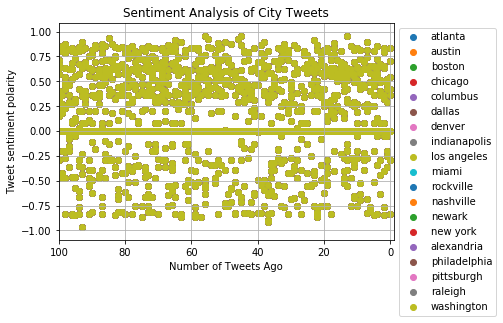

In [65]:
plt.xlim(100,-1)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Sentiment Analysis of City Tweets")
plt.xlabel("Number of Tweets Ago")
plt.ylabel("Tweet sentiment polarity")
#plt.savefig("Sentiment Analysis of News Tweets")
plt.grid(True)
plt.show()

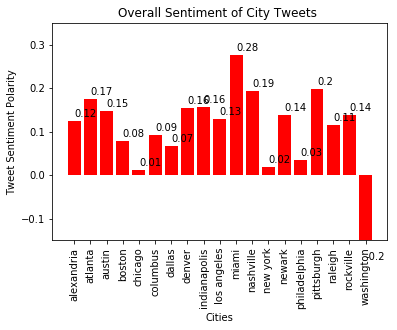

In [85]:
fig, ax = plt.subplots()

mean_sentiments =avg_sent["Compound"].mean()

x_axis = np.arange(len(mean_sentiments))
count2 = 0
count = 0
for sent in mean_sentiments:
    ax.text(count2, sent+.01, str(round(sent,2)))
    count2+=1
plt.ylim(-.15,.35)
plt.bar(x_axis, mean_sentiments, tick_label = list(mean_sentiments.index), color = 'r')
plt.title("Overall Sentiment of City Tweets ")
plt.xlabel("Cities")
plt.ylabel("Tweet Sentiment Polarity")
plt.xticks(rotation=90)
#plt.savefig("Overall Sentiment of City Tweets")
plt.show()

In [68]:
for sent in means_sentiments:
    print(sent)

City
Compound
Degree_score


City
alexandria      0.124065
atlanta         0.173942
austin          0.147265
boston          0.078493
chicago         0.010986
columbus        0.092735
dallas          0.066886
denver          0.155278
indianapolis    0.155943
los angeles     0.129343
miami           0.277160
nashville       0.193239
new york        0.018357
newark          0.138080
philadelphia    0.034603
pittsburgh      0.197391
raleigh         0.114362
rockville       0.138819
washington     -0.203734
Name: Compound, dtype: float64

mean_sentiments.index